## Task 3 需求分析：
- 阅读论文 Enhanced LSTM for Natural Language Inference
- 还原出原论文代码中 BiLSTM 机制
- 在给定语料库中完成给定两个句子关系的分析

### 论文中提到的 ESIM 结构
ESIM 的结构：
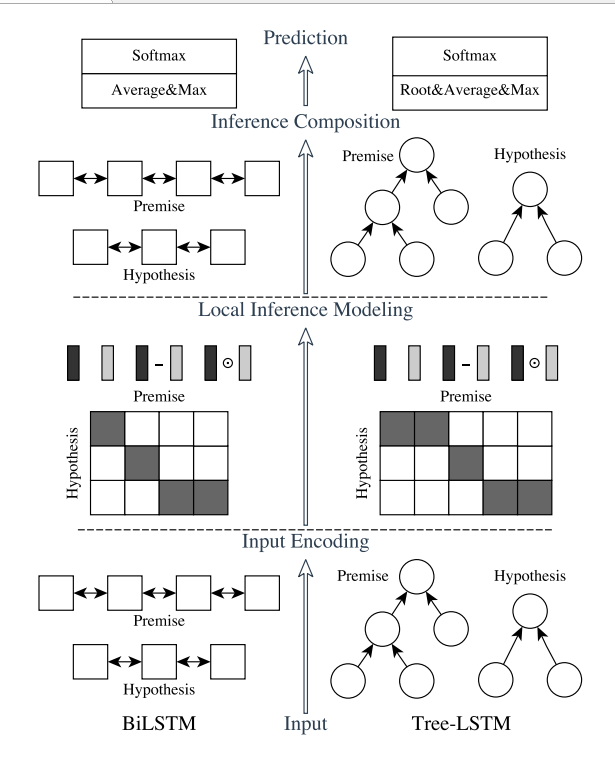

### 使用 BiLSTM 对句子进行编码
由于需要对句子进行相似性分析，所以首先对输入 hyp 和 pre 进行编码，编码方式为双向 LSTM 编码的方法，双向 LSTM 编码的模型为：
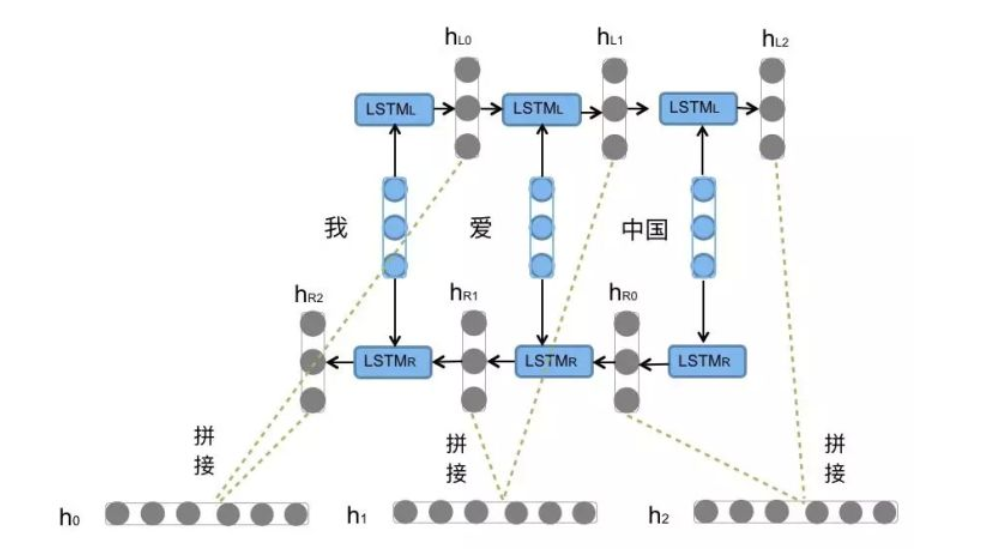


这里用到的编码方式为：
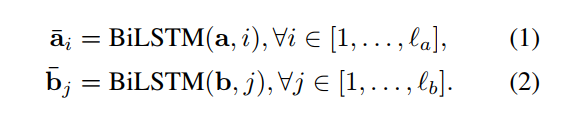

In [ ]:
# 读入对应的句子：
# size：batch_size * seq_maxlen
sent1, sent2 = input1, input2
mask1, mask2 = sent1.eq(0), sent2.eq(0)

# 将读入的句子转为对应的 embeding matrix
# size: batch_size * seq_maxlen => batch_size * seq_maxlen * embeds_dim
# 这里使用 contiguous 是为了保证处理原句子的同时不改变原先句子的结构，参考链接：https://blog.csdn.net/gdymind/article/details/82662502
x1 = self.bn_embeds(self.embeds(sent1).transpose(1, 2).contiguous()).transpose(1, 2)
x2 = self.bn_embeds(self.embeds(sent2).transpose(1, 2).contiguous()).transpose(1, 2)

# 进行 BiLSTM 处理
# size：batch_size * maxseq_len * embeds_dim => batch_size * maxseq_len * hidden_size
o1, _ = self.lstm1(x1)
o2, _ = self.lstm1(x2)    

### 注意力机制

使用`注意力机制`来计算任意任意两个词之间的关联程度，而论文中使用的是注意力机制中的软注意力机制；
- 任意两个词的注意力关系为:
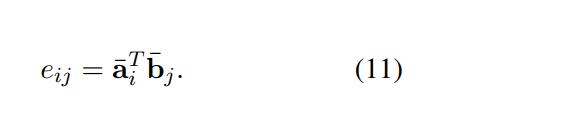
- 句子与句子间的注意力关系为：
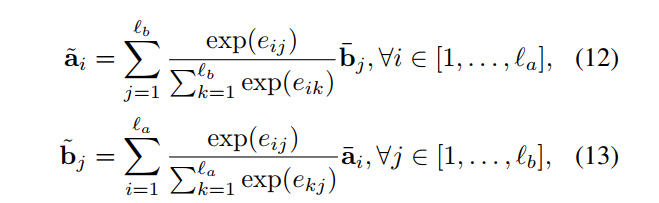

In [2]:
# 软注意力机制实现
def soft_align_attention(self, x1, x2, mask1, mask2):
    '''
     x1: batch_size * seq_len * hidden_size
     x2: batch_size * seq_len * hidden_size
    '''
    # attention: batch_size * seq_len * seq_len
    attention = torch.matmul(x1, x2.transpose(1, 2))
    mask1 = mask1.float().masked_fill_(mask1, float('-inf'))
    mask2 = mask2.float().masked_fill_(mask2, float('-inf'))

    # weight: batch_size * seq_len * seq_len
    weight1 = F.softmax(attention + mask2.unsqueeze(1), dim=-1)
    x1_align = torch.matmul(weight1, x2)
    weight2 = F.softmax(attention.transpose(1, 2) + mask1.unsqueeze(1), dim=-1)
    x2_align = torch.matmul(weight2, x1)
   
    # x_align: batch_size * seq_len * hidden_size
     return x1_align, x2_align    

IndentationError: unexpected indent (<ipython-input-2-f21c1f383bf0>, line 19)

###  矩阵拼接

完成句子之间注意力机制的计算之后，就可以进一步进行接下来的运算：
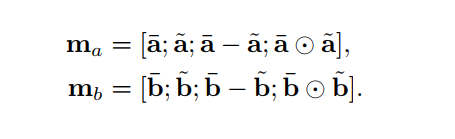
在这里需要完成矩阵的拼接，与矩阵的减法和点乘运算

In [ ]:
#矩阵点乘与减法操作
def submul(self, x1, x2):
    mul = x1 * x2
    sub = x1 - x2
    return torch.cat([sub, mul], -1)


# 完成矩阵拼接
q1_combined = torch.cat([o1, q1_align, self.submul(o1, q1_align)], -1)
q2_combined = torch.cat([o2, q2_align, self.submul(o2, q2_align)], -1)

### 通过下一层 BiLSTM


完成上步之后得到一系列拼接在一起的向量，随后再次经过一个 BiLSTM：
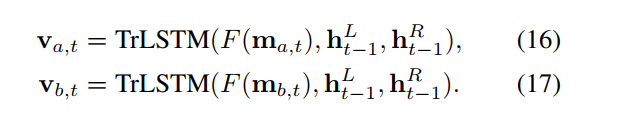
这里由于使用 BiLSTM 就只需要一个变量$m_a 或者 m_b$ 

In [ ]:
# 再次进行 BiLSTM 操作得到最终特征
q1_compose, _ = self.lstm2(q1_combined)
q2_compose, _ = self.lstm2(q2_combined)

### 最终池化操作

In [1]:
# 池化操作
def apply_multiple(self, x):
    p1 = F.avg_pool1d(x.transpose(1, 2), x.size(1)).squeeze(-1)
    p2 = F.max_pool1d(x.transpose(1, 2), x.size(1)).squeeze(-1)
    return torch.cat([p1, p2], 1)

### 使用 softmax 进行分类 

In [ ]:
# 完成分类得到最终结果
x = torch.cat([q1_rep, q2_rep], -1)
sim = self.fc(x)

## Task3 完整实现

In [39]:
# 读入数据
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
file_train = pd.read_csv('train.txt', header=0, delimiter="\t", quoting=3)

# 进行分词处理
word_tokenizer = WordPunctTokenizer()
def textPreprocess(text):
    words = word_tokenizer.tokenize(text)
    return ' '.join(words)
# 处理输入的 pre hys label
file_train['sentence1'] = file_train['sentence1'].apply(textPreprocess)
file_train['sentence2'] = file_train['sentence2'].apply(textPreprocess)
file_train['gold_label'] = file_train['gold_label'].map({'neutral': 0, 'contradiction': 1, 'entailment': 2})

In [5]:
# 创建 voacb
word_set = set()
for i in range(0, file_train['sentence1'].size):
    word_set.update([w.lower() for w in word_tokenizer.tokenize(file_train['sentence1'][i])])
for i in range(0, file_train['sentence2'].size):
    word_set.update([w.lower() for w in word_tokenizer.tokenize(file_train['sentence2'][i])]) 
print(len(word_set))

240


In [6]:
# 定义 embeding vector 选择使用谷歌预训练的glove
def load_glove_embedding(word_list, uniform_scale, dimension_size):
    index = 0
    if os.path.exists('glove_embedding.npy'):
        word_vectors = np.load('glove_embedding.npy')
        print('Successfully load saved embedding!')
    else:
        glove_words = {}
        with open('C:/Users/WYX/Desktop/test/glove.840B.300d.txt', 'r',encoding='utf-8') as fopen:
            for line in fopen:
                tmp = line.split(' ')
                glove_words[tmp[0]] = np.array(tmp[1:], dtype=np.float32)

        word_to_index = {}
        word_vectors = np.zeros([len(word_set), 300])
        for word in word_list:
            word_to_index[word] = index
            index += 1
            if word in glove_words:
                word_vectors[word_to_index[word]] = (glove_words[word])
            elif word == '<pad>':
                word_vectors[word_to_index[word]] = (np.zeros(dimension_size, dtype=np.float32))
            else:
                word_vectors[word_to_index[word]] = (np.random.uniform(-uniform_scale, uniform_scale, dimension_size))
        
    return word_vectors, word_to_index

In [7]:
# 创建 embedding matrix
import os
import numpy as np
word_vectors, word_to_index = load_glove_embedding(word_set, 0.25, 300)

In [8]:
# 禁用 GPU
import torch
is_cuda = False 

In [49]:
# 构建 ESIM 类
from torch import nn
import torch
import torch.nn.functional as F


class ESIM(nn.Module):
    def __init__(self,num_word,word_vectors):
        super(ESIM, self).__init__()
        self.dropout = 0.5
        self.hidden_size = 10
        self.embeds_dim = 300 
        self.embeds = nn.Embedding(num_word, self.embeds_dim)
        self.embeds.weight.data.copy_(torch.from_numpy(word_vectors))
        self.bn_embeds = nn.BatchNorm1d(self.embeds_dim)
        self.lstm1 = nn.LSTM(self.embeds_dim, self.hidden_size, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(self.hidden_size*8, self.hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.BatchNorm1d(self.hidden_size * 8),
            nn.Linear(self.hidden_size * 8, 10),
            nn.ELU(inplace=True),
            nn.BatchNorm1d(10),
            nn.Dropout(self.dropout),
            nn.Linear(10, 10),
            nn.ELU(inplace=True),
            nn.BatchNorm1d(10),
            nn.Dropout(self.dropout),
            nn.Linear(10, 3),
            nn.Softmax(dim=-1)
        )
    
    def soft_attention_align(self, x1, x2, mask1, mask2):
        attention = torch.matmul(x1, x2.transpose(1, 2))
        mask1 = mask1.float().masked_fill_(mask1, float('-inf'))
        mask2 = mask2.float().masked_fill_(mask2, float('-inf'))
        weight1 = F.softmax(attention + mask2.unsqueeze(1), dim=-1)
        x1_align = torch.matmul(weight1, x2)
        weight2 = F.softmax(attention.transpose(1, 2) + mask1.unsqueeze(1), dim=-1)
        x2_align = torch.matmul(weight2, x1)
        return x1_align, x2_align

    def submul(self, x1, x2):
        mul = x1 * x2
        sub = x1 - x2
        return torch.cat([sub, mul], -1)

    def apply_multiple(self, x):
        p1 = F.avg_pool1d(x.transpose(1, 2), x.size(1)).squeeze(-1)
        p2 = F.max_pool1d(x.transpose(1, 2), x.size(1)).squeeze(-1)
        return torch.cat([p1, p2], 1)

    def forward(self, input1,input2):
        sent1, sent2 = input1, input2
        mask1, mask2 = sent1.eq(0), sent2.eq(0)
        x1 = self.bn_embeds(self.embeds(sent1).transpose(1, 2).contiguous()).transpose(1, 2)
        x2 = self.bn_embeds(self.embeds(sent2).transpose(1, 2).contiguous()).transpose(1, 2)
        o1, _ = self.lstm1(x1)
        o2, _ = self.lstm1(x2) 
        q1_align, q2_align = self.soft_attention_align(o1, o2, mask1, mask2)
        q1_combined = torch.cat([o1, q1_align, self.submul(o1, q1_align)], -1)
        q2_combined = torch.cat([o2, q2_align, self.submul(o2, q2_align)], -1)
        q1_compose, _ = self.lstm2(q1_combined)
        q2_compose, _ = self.lstm2(q2_combined)
        q1_rep = self.apply_multiple(q1_compose)
        q2_rep = self.apply_multiple(q2_compose)
        x = torch.cat([q1_rep, q2_rep], -1)
        similarity = self.fc(x)
        return similarity

In [10]:
# 将所有输入向量拼接成相同长度
max_len_1 = max([len(s.split()) for s in file_train['sentence1']])

max_len_2 = max([len(s.split()) for s in file_train['sentence2']])

max_len = 0 
if max_len_1 > max_len_2:
    max_len = max_len_1
else:
    max_len = max_len_2

In [11]:
# 定义 linetoindex
def lineToIndex(line):
    words = [w.lower() for w in word_tokenizer.tokenize(line)]
    words_index = []
    for w in words:
        words_index.append(word_to_index[w])
    #print(len(words_index))
    while len(words_index) < max_len:
        words_index.append(0)
    return words_index

def polarityFromOutput(output):
    top_n, top_i = output.topk(1)
    polarity = top_i[0].item()
    return polarity

In [52]:
# 创建模型
esim = ESIM(len(word_set),word_vectors)

#output = esim(torch.tensor([[1,0,1],[1,0,2]]),torch.tensor([[1,0,1],[1,0,3]]))
#print(torch.tensor([[1,0,1],[1,0,2]]))

import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(esim.parameters(),lr=0.00004)

import time
import math
import numpy as np
current_loss = 0
start = time.time()

Xtrain_1 = []
Xtrain_2 = [] 
for i in file_train['sentence1']:
    Xtrain_1.append(lineToIndex(i))

for i in file_train['sentence2']:
    Xtrain_2.append(lineToIndex(i))

Xtrain_1 = np.array(Xtrain_1)
Xtrain_2 = np.array(Xtrain_2)
Ytrain = np.array(file_train['gold_label'])
epoch_size = 32

def train(model, category_tensor, line_tensor1, line_tensor2):
    output = model(line_tensor1,line_tensor2)
    #print(output)
    model.zero_grad()
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
EPOCH = 10
for j in range(1,EPOCH):
    print('Now is epoch {}'.format(j))
    for i in range(0,(int)(len(Xtrain_1)/epoch_size)):
        line_tensor1 = torch.LongTensor(Xtrain_1[i*epoch_size:i*epoch_size+epoch_size])
        line_tensor2 = torch.LongTensor(Xtrain_2[i*epoch_size:i*epoch_size+epoch_size])
        polarity_tensor = torch.tensor(Ytrain[i*epoch_size:i*epoch_size+epoch_size])
        #print(line_tensor1.shape)
        #print(line_tensor1)
        #print(line_tensor2.shape)
        #print(line_tensor2)
        output, loss = train(esim,polarity_tensor,line_tensor1,line_tensor2)
        print('loss: {}'.format(timeSince(start), i, 100, loss))
        pred_y = torch.max(output,1)[1].data.squeeze()
        acc = (polarity_tensor == pred_y)
        acc = acc.numpy().sum()
        accuracy = acc / (polarity_tensor.size(0))
        print('acc is: {}'.format(accuracy))

Now is epoch 1
loss: 0m 0s
acc is: 0.375
loss: 0m 0s
acc is: 0.1875
loss: 0m 1s
acc is: 0.375
loss: 0m 1s
acc is: 0.3125
loss: 0m 1s
acc is: 0.3125
loss: 0m 1s
acc is: 0.3125
loss: 0m 2s
acc is: 0.28125
loss: 0m 2s
acc is: 0.375
loss: 0m 2s
acc is: 0.40625
loss: 0m 3s
acc is: 0.3125
loss: 0m 3s
acc is: 0.1875
loss: 0m 3s
acc is: 0.28125
loss: 0m 3s
acc is: 0.34375
loss: 0m 4s
acc is: 0.3125
loss: 0m 4s
acc is: 0.34375
loss: 0m 4s
acc is: 0.28125
loss: 0m 5s
acc is: 0.375
loss: 0m 5s
acc is: 0.3125
loss: 0m 5s
acc is: 0.3125
loss: 0m 6s
acc is: 0.25
loss: 0m 6s
acc is: 0.5
loss: 0m 6s
acc is: 0.375
loss: 0m 6s
acc is: 0.375
loss: 0m 7s
acc is: 0.3125
loss: 0m 7s
acc is: 0.375
loss: 0m 7s
acc is: 0.28125
loss: 0m 8s
acc is: 0.28125
loss: 0m 8s
acc is: 0.46875
loss: 0m 8s
acc is: 0.28125
loss: 0m 9s
acc is: 0.34375
loss: 0m 9s
acc is: 0.28125
Now is epoch 2
loss: 0m 9s
acc is: 0.34375
loss: 0m 9s
acc is: 0.28125
loss: 0m 10s
acc is: 0.40625
loss: 0m 10s
acc is: 0.25
loss: 0m 10s
acc is: 0

In [1]:
# 由于计算机计算能力有限 只对模型进行了部分数据集的验证